# NetColoc analysis of rare variants in Autism spectrum disorder (ASD). 

Example of NetColoc workflow on genes associated with rare exome variants in ASD only, to demonstrate workflow from single gene set





# _Obtain input gene sets and interactome_

## 1. Load required packages

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

In [2]:
from netcoloc import netprop_zscore, netprop, network_colocalization, validation

## 2. Select one gene set of interest. Load gene set from text files into python.


Identify one gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [3]:
# set names of geneset 1
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='ASD'


In [4]:
# ------ customize this section based your input genesets -------

# load rare variants Satterstrom et al 2020; PMID: 31981491
D1_df = pd.read_csv('data/Satterstrom--Top-102-ASD-genes--May2019.csv')
D1_df.index = D1_df['gene']
print('Number of '+d1_name+' genes:', len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1_genes[0:5])

Number of ASD genes: 102
First 5 genes: ['CHD8', 'SCN2A', 'SYNGAP1', 'ADNP', 'FOXP1']


## 3. Select gene interaction network to use for the analysis.

Identify network UUID on NDEx (ndexbio.org) and use this to import to this Jupyter notebook. We recommend using PCNet as a starting point, but a user may want to switch to “STRING high confidence” if using a machine with low memory (< 8GB RAM).


In [5]:
# interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 16201

Number of edges: 236930


In [6]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks) 

A benchmarking analysis demonstrates that the runtime required scales with the number of edges (w’) and the number of nodes (w’’). NetColoc includes functionality for saving and loading these matrices, by setting the XXX parameter, which can be useful if running multiple analyses. The diffusion parameter, which controls the rate of propagation through the network, may be set in this step. In practice, we have found that results are not dependent on the choice of this parameter, and recommend using the default value of 0.5.

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [7]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)

# w_double_prime can be saved to the file netcoloc_w_double_prime.npy
# in current working directory with the following call:
#
# np.save('netcoloc_w_double_prime.npy', w_double_prime)

# and reloaded later with:
# w_double_prime = np.load('netcoloc_w_double_prime.npy')
#
# NOTE: Saving w_double_prime results in a several gigabyte file and
#       takes a minute or more to save and load



calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network. 

Only genes contained in the interaction network will be retained for downstream analysis. 


In [8]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print("Number of D1 genes in interactome:", len(D1_genes))




Number of D1 genes: 102
Number of D1 genes in interactome: 76


## 6. Compute network proximity scores from seed gene set.

The network proximity scores include a correction for the degree distribution of the input gene sets. The runtime required for computing the network proximity scores increases linearly with the number of nodes in the underlying interaction network and with the size of the input gene list

In [9]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
TCF20,13.894331
PHF2,11.034771
RFX3,10.759614
WAC,10.168940
SKI,8.947080


## 7. Build proximal subnetwork by taking z> thresh 

Select genes which have z>threshold (default = 3). These genes are proximal in network space to the seed gene set

In [10]:
# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3

# select the genes in the network intersection, make a subgraph

G_prox = nx.subgraph(G_int,z_D1[z_D1['z']>zthresh].index.tolist()) 
print("Nodes in proximal subgraph:", len(G_prox.nodes()))
print("Edges in proximal subgraph:", len(G_prox.edges()))

Nodes in proximal subgraph: 348
Edges in proximal subgraph: 809


## 8. Transform NetColoc proximal subnetwork edges to cosine similarities (OPTIONAL)

Transform NetColoc subnetwork edges to cosine similarities, with the function ‘network_colocalization.transform_edges’. The cosine similarity score between two genes represents the extent to which those genes have similar interactors. In practice, the cosine similarity transformed score helps to visually reveal the underlying clustering structure present in a network. 



In [11]:
G_cosSim=network_colocalization.transform_edges(G_prox,method='cosine_sim',edge_weight_threshold=0.95)

# _Compute systems map from proximal subgraph_

## 9. Convert network colocalization subnetwork to form used in community detection module

In [12]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_prox.nodes))
node_df = node_df.assign(d1_seeds=0, d1_name=d1_name,)
node_df.loc[list(np.intersect1d(D1_genes,node_df.index.tolist())), 'd1_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_prox.nodes)]['z']
node_df['sum_seeds']=node_df['d1_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
node_df.head(15)

,d1_seeds,d1_name,z_d1,sum_seeds
TCF20,1,ASD,13.894331,1
PHF2,1,ASD,11.034771,1
RFX3,1,ASD,10.759614,1
WAC,1,ASD,10.168940,1
SKI,1,ASD,8.947080,1
ELAVL3,1,ASD,8.886017,1
ANKRD11,1,ASD,8.873450,1
KDM6B,1,ASD,8.803796,1
TLK2,1,ASD,8.728659,1
MBD5,1,ASD,8.394882,1


## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [13]:
print("Nodes in overlap subgraph:", len(G_prox.nodes()))
print("Edges in overlap subgraph:", len(G_prox.edges()))
# Create cx format of overlap subgraph
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_prox_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

Nodes in overlap subgraph: 348
Edges in overlap subgraph: 809


In [14]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ASD_NetColoc_subgraph
# nodes: 105
# edges: 118


In [15]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.


In [16]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))


Number of nodes: 105

Number of edges: 118


In [17]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,SCAF11 PLAGL2 RARA PHF23 ATE1 SMAD9 HDGFRP2 DC...,342,False,8.418,,,0,0.0,0.0,0,C348,C348,0
1,PPP1R15B WDYHV1 DTX2 UBR5 RNF20 ANK2 ensembl:E...,44,False,5.459,,,0,0.0,0.0,57,C353,C353,1
2,TM9SF4 PLAGL2 POFUT1 SEC24C,4,False,2.0,,,0,0.0,0.0,237,C439,C439,2
3,SKIL SKI ensembl:ENSP00000305769 SMURF2 ensemb...,6,False,2.585,,,0,0.0,0.0,146,C414,C414,3
4,USP34 TRIP12 GON4L USP9X SETD2 ensembl:ENSP000...,9,False,3.17,,,0,0.0,0.0,12,C394,C394,4


Annotate hierarchy with seed gene information

In [18]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds = []
frac_d1_seeds=[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,D1_genes))

    num_d1_temp = len(d1_temp)
    if (num_d1_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_d1_seeds.append(num_d1_temp)
        
        frac_d1_seeds.append((num_d1_temp)/float(len(system_genes)))
    else:
        for stat in [num_d1_seeds, frac_d1_seeds]:
            stat.append(0)

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds]).sum(axis=0))
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_no_seeds']=frac_no_seeds

## 12. Remove systems with no seed genes (OPTIONAL)

In [19]:
hier_df = hier_df.loc[systems_keep]
print("Number of nodes with seed genes:", len(hier_df))
hier_df.head()
    

Number of nodes with seed genes: 104


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,frac_d1_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,
C348,SCAF11 PLAGL2 RARA PHF23 ATE1 SMAD9 HDGFRP2 DC...,342,False,8.418,,,0,0.0,0.0,0,C348,C348,0,71,0.207602,0.792398
C353,PPP1R15B WDYHV1 DTX2 UBR5 RNF20 ANK2 ensembl:E...,44,False,5.459,,,0,0.0,0.0,57,C353,C353,1,9,0.204545,0.795455
C439,TM9SF4 PLAGL2 POFUT1 SEC24C,4,False,2.0,,,0,0.0,0.0,237,C439,C439,2,1,0.250000,0.750000
C414,SKIL SKI ensembl:ENSP00000305769 SMURF2 ensemb...,6,False,2.585,,,0,0.0,0.0,146,C414,C414,3,1,0.166667,0.833333
C394,USP34 TRIP12 GON4L USP9X SETD2 ensembl:ENSP000...,9,False,3.17,,,0,0.0,0.0,12,C394,C394,4,2,0.222222,0.777778


In [20]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

Number of nodes with seed genes: 104
Number of edges remaining: 117


## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [21]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler. 

Annotate moderately sized systems (between 50 to 1000 genes per system) if they are significantly enriched for a Gene Ontology biological process. Also require that the GO term is enriched with $p<10^{-5}$ and shares at least 3 genes with the system to annotate, to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [22]:
# gprofiler annotation of clusters

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C348
342


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
4,HDMs demethylate histones,10842,10,HDMs demethylate histones,REAC:R-HSA-3214842,5.132476e-07,[REAC:R-HSA-3247509],0.059880,query_1,167,0.196078,True,REAC,51
6,PKMTs methylate histone lysines,10842,10,PKMTs methylate histone lysines,REAC:R-HSA-3214841,8.850050e-06,[REAC:R-HSA-3247509],0.059880,query_1,167,0.142857,True,REAC,70
1,Chromatin organization,10842,29,Chromatin organization,REAC:R-HSA-4839726,2.994231e-14,[REAC:0000000],0.173653,query_1,167,0.106618,True,REAC,272
0,Chromatin modifying enzymes,10842,29,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.994231e-14,[REAC:R-HSA-4839726],0.173653,query_1,167,0.106618,True,REAC,272
2,SUMO E3 ligases SUMOylate target proteins,10842,18,SUMO E3 ligases SUMOylate target proteins,REAC:R-HSA-3108232,2.191203e-08,[REAC:R-HSA-2990846],0.107784,query_1,167,0.105882,True,REAC,170


C353
44


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,E3 ubiquitin ligases ubiquitinate target proteins,10842,5,E3 ubiquitin ligases ubiquitinate target proteins,REAC:R-HSA-8866654,0.000010,[REAC:R-HSA-8852135],0.208333,query_1,24,0.086207,True,REAC,58
0,Protein ubiquitination,10842,6,Protein ubiquitination,REAC:R-HSA-8852135,0.000002,[REAC:R-HSA-597592],0.250000,query_1,24,0.076923,True,REAC,78


C439
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C414
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Signaling by TGFB family members,10842,4,Signaling by TGFB family members,REAC:R-HSA-9006936,4.139967e-07,[REAC:R-HSA-162582],1.0,query_1,4,0.033613,True,REAC,119


C394
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C369
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C381
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C401
7


""


C413
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C440
4


""


C441
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C378
13


""


C411
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C412
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C349
151


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
4,HDMs demethylate histones,10842,10,HDMs demethylate histones,REAC:R-HSA-3214842,1.936567e-10,[REAC:R-HSA-3247509],0.1250,query_1,80,0.196078,True,REAC,51
5,PKMTs methylate histone lysines,10842,10,PKMTs methylate histone lysines,REAC:R-HSA-3214841,4.478808e-09,[REAC:R-HSA-3247509],0.1250,query_1,80,0.142857,True,REAC,70
13,Cytoprotection by HMOX1,10842,7,Cytoprotection by HMOX1,REAC:R-HSA-9707564,8.345879e-06,[REAC:R-HSA-9711123],0.0875,query_1,80,0.112903,True,REAC,62
7,Transcriptional regulation of white adipocyte ...,10842,9,Transcriptional regulation of white adipocyte ...,REAC:R-HSA-381340,3.500835e-07,[REAC:R-HSA-1266738],0.1125,query_1,80,0.109756,True,REAC,82
1,Chromatin organization,10842,29,Chromatin organization,REAC:R-HSA-4839726,2.601438e-24,[REAC:0000000],0.3625,query_1,80,0.106618,True,REAC,272


C350
59


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,GABA receptor activation,10842,8,GABA receptor activation,REAC:R-HSA-977443,1.405504e-10,[REAC:R-HSA-112314],0.25000,query_1,32,0.133333,True,REAC,60
9,Signaling by ERBB4,10842,5,Signaling by ERBB4,REAC:R-HSA-1236394,3.781284e-06,[REAC:R-HSA-9006934],0.15625,query_1,32,0.092593,True,REAC,54
10,Neurexins and neuroligins,10842,5,Neurexins and neuroligins,REAC:R-HSA-6794361,4.134759e-06,[REAC:R-HSA-6794362],0.15625,query_1,32,0.089286,True,REAC,56
1,Transmission across Chemical Synapses,10842,15,Transmission across Chemical Synapses,REAC:R-HSA-112315,5.073944e-15,[REAC:R-HSA-112316],0.46875,query_1,32,0.057915,True,REAC,259
3,Neurotransmitter receptors and postsynaptic si...,10842,10,Neurotransmitter receptors and postsynaptic si...,REAC:R-HSA-112314,2.773696e-09,[REAC:R-HSA-112315],0.31250,query_1,32,0.051020,True,REAC,196


C351
50


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C352
44


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,PKMTs methylate histone lysines,10842,9,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.770076e-13,[REAC:R-HSA-3247509],0.391304,query_1,23,0.128571,True,REAC,70
3,HDMs demethylate histones,10842,6,HDMs demethylate histones,REAC:R-HSA-3214842,1.158277e-08,[REAC:R-HSA-3247509],0.260870,query_1,23,0.117647,True,REAC,51
1,Chromatin organization,10842,17,Chromatin organization,REAC:R-HSA-4839726,1.010065e-21,[REAC:0000000],0.739130,query_1,23,0.062500,True,REAC,272
0,Chromatin modifying enzymes,10842,17,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.010065e-21,[REAC:R-HSA-4839726],0.739130,query_1,23,0.062500,True,REAC,272


C384
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C387
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HDMs demethylate histones,10842,8,HDMs demethylate histones,REAC:R-HSA-3214842,2.965976e-18,[REAC:R-HSA-3247509],1.0,query_1,8,0.156863,True,REAC,51
1,Chromatin modifying enzymes,10842,8,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.039862e-12,[REAC:R-HSA-4839726],1.0,query_1,8,0.029412,True,REAC,272
2,Chromatin organization,10842,8,Chromatin organization,REAC:R-HSA-4839726,1.039862e-12,[REAC:0000000],1.0,query_1,8,0.029412,True,REAC,272


C357
31


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
6,Cytoprotection by HMOX1,10842,6,Cytoprotection by HMOX1,REAC:R-HSA-9707564,3.324887e-08,[REAC:R-HSA-9711123],0.285714,query_1,21,0.096774,True,REAC,62
10,Regulation of cholesterol biosynthesis by SREB...,10842,5,Regulation of cholesterol biosynthesis by SREB...,REAC:R-HSA-1655829,5.295453e-07,[REAC:R-HSA-8957322],0.238095,query_1,21,0.094340,True,REAC,53
13,Transcriptional activation of mitochondrial bi...,10842,5,Transcriptional activation of mitochondrial bi...,REAC:R-HSA-2151201,5.295453e-07,[REAC:R-HSA-1592230],0.238095,query_1,21,0.094340,True,REAC,53
17,Circadian Clock,10842,5,Circadian Clock,REAC:R-HSA-400253,1.362363e-06,[REAC:0000000],0.238095,query_1,21,0.074627,True,REAC,67
7,Transcriptional regulation of white adipocyte ...,10842,6,Transcriptional regulation of white adipocyte ...,REAC:R-HSA-381340,1.618112e-07,[REAC:R-HSA-1266738],0.285714,query_1,21,0.073171,True,REAC,82


C391
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C360
25


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,UCH proteinases,10842,8,UCH proteinases,REAC:R-HSA-5689603,8.155508e-11,[REAC:R-HSA-5688426],0.470588,query_1,17,0.079208,True,REAC,101
1,Deubiquitination,10842,9,Deubiquitination,REAC:R-HSA-5688426,6.487197e-09,[REAC:R-HSA-597592],0.529412,query_1,17,0.030303,True,REAC,297


C362
23


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C371
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C373
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C379
13


""


C354
44


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
6,Neurexins and neuroligins,10842,5,Neurexins and neuroligins,REAC:R-HSA-6794361,1.056169e-06,[REAC:R-HSA-6794362],0.217391,query_1,23,0.089286,True,REAC,56
8,Protein-protein interactions at synapses,10842,5,Protein-protein interactions at synapses,REAC:R-HSA-6794362,7.183917e-06,[REAC:R-HSA-112316],0.217391,query_1,23,0.058140,True,REAC,86
0,Neuronal System,10842,11,Neuronal System,REAC:R-HSA-112316,1.050985e-08,[REAC:0000000],0.478261,query_1,23,0.027500,True,REAC,400
2,Axon guidance,10842,11,Axon guidance,REAC:R-HSA-422475,7.744090e-08,[REAC:R-HSA-9675108],0.478261,query_1,23,0.020036,True,REAC,549
5,Nervous system development,10842,11,Nervous system development,REAC:R-HSA-9675108,8.080917e-08,[REAC:R-HSA-1266738],0.478261,query_1,23,0.019164,True,REAC,574


C355
36


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,GABA receptor activation,10842,8,GABA receptor activation,REAC:R-HSA-977443,8.859662e-13,[REAC:R-HSA-112314],0.40,query_1,20,0.133333,True,REAC,60
5,Signaling by ERBB4,10842,5,Signaling by ERBB4,REAC:R-HSA-1236394,2.538375e-07,[REAC:R-HSA-9006934],0.25,query_1,20,0.092593,True,REAC,54
1,Transmission across Chemical Synapses,10842,13,Transmission across Chemical Synapses,REAC:R-HSA-112315,8.375517e-16,[REAC:R-HSA-112316],0.65,query_1,20,0.050193,True,REAC,259
3,Neurotransmitter receptors and postsynaptic si...,10842,8,Neurotransmitter receptors and postsynaptic si...,REAC:R-HSA-112314,1.060416e-08,[REAC:R-HSA-112315],0.40,query_1,20,0.040816,True,REAC,196
0,Neuronal System,10842,15,Neuronal System,REAC:R-HSA-112316,1.326393e-16,[REAC:0000000],0.75,query_1,20,0.037500,True,REAC,400


C361
23


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,Neurexins and neuroligins,10842,4,Neurexins and neuroligins,REAC:R-HSA-6794361,0.000004,[REAC:R-HSA-6794362],0.333333,query_1,12,0.071429,True,REAC,56
4,Axon guidance,10842,7,Axon guidance,REAC:R-HSA-422475,0.000006,[REAC:R-HSA-9675108],0.583333,query_1,12,0.012750,True,REAC,549
5,Nervous system development,10842,7,Nervous system development,REAC:R-HSA-9675108,0.000006,[REAC:R-HSA-1266738],0.583333,query_1,12,0.012195,True,REAC,574


C358
27


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C448
4


""


C443
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C356
35


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,HDMs demethylate histones,10842,6,HDMs demethylate histones,REAC:R-HSA-3214842,2.950809e-09,[REAC:R-HSA-3247509],0.315789,query_1,19,0.117647,True,REAC,51
2,PKMTs methylate histone lysines,10842,8,PKMTs methylate histone lysines,REAC:R-HSA-3214841,2.713700e-12,[REAC:R-HSA-3247509],0.421053,query_1,19,0.114286,True,REAC,70
1,Chromatin organization,10842,16,Chromatin organization,REAC:R-HSA-4839726,4.098812e-22,[REAC:0000000],0.842105,query_1,19,0.058824,True,REAC,272
0,Chromatin modifying enzymes,10842,16,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.098812e-22,[REAC:R-HSA-4839726],0.842105,query_1,19,0.058824,True,REAC,272


C367
18


""


C359
26


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,E3 ubiquitin ligases ubiquitinate target proteins,10842,5,E3 ubiquitin ligases ubiquitinate target proteins,REAC:R-HSA-8866654,6.385494e-07,[REAC:R-HSA-8852135],0.294118,query_1,17,0.086207,True,REAC,58
0,Protein ubiquitination,10842,6,Protein ubiquitination,REAC:R-HSA-8852135,7.818283e-08,[REAC:R-HSA-597592],0.352941,query_1,17,0.076923,True,REAC,78


C363
21


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C372
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,GABA receptor activation,10842,8,GABA receptor activation,REAC:R-HSA-977443,5.340125e-17,[REAC:R-HSA-112314],0.888889,query_1,9,0.133333,True,REAC,60
4,Signaling by ERBB4,10842,5,Signaling by ERBB4,REAC:R-HSA-1236394,6.923127e-10,[REAC:R-HSA-9006934],0.555556,query_1,9,0.092593,True,REAC,54
3,Neurotransmitter receptors and postsynaptic si...,10842,8,Neurotransmitter receptors and postsynaptic si...,REAC:R-HSA-112314,3.191274e-13,[REAC:R-HSA-112315],0.888889,query_1,9,0.040816,True,REAC,196
1,Transmission across Chemical Synapses,10842,9,Transmission across Chemical Synapses,REAC:R-HSA-112315,1.214735e-14,[REAC:R-HSA-112316],1.000000,query_1,9,0.034749,True,REAC,259
2,Neuronal System,10842,9,Neuronal System,REAC:R-HSA-112316,3.191274e-13,[REAC:0000000],1.000000,query_1,9,0.022500,True,REAC,400


C382
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,HDMs demethylate histones,10842,6,HDMs demethylate histones,REAC:R-HSA-3214842,8.858287e-12,[REAC:R-HSA-3247509],0.666667,query_1,9,0.117647,True,REAC,51
0,Chromatin modifying enzymes,10842,9,Chromatin modifying enzymes,REAC:R-HSA-3247509,6.910660e-14,[REAC:R-HSA-4839726],1.000000,query_1,9,0.033088,True,REAC,272
1,Chromatin organization,10842,9,Chromatin organization,REAC:R-HSA-4839726,6.910660e-14,[REAC:0000000],1.000000,query_1,9,0.033088,True,REAC,272


C421
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C374
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C400
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C388
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C366
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Cytoprotection by HMOX1,10842,6,Cytoprotection by HMOX1,REAC:R-HSA-9707564,1.755425e-09,[REAC:R-HSA-9711123],0.500000,query_1,12,0.096774,True,REAC,62
10,Regulation of cholesterol biosynthesis by SREB...,10842,5,Regulation of cholesterol biosynthesis by SREB...,REAC:R-HSA-1655829,2.308324e-08,[REAC:R-HSA-8957322],0.416667,query_1,12,0.094340,True,REAC,53
9,Transcriptional activation of mitochondrial bi...,10842,5,Transcriptional activation of mitochondrial bi...,REAC:R-HSA-2151201,2.308324e-08,[REAC:R-HSA-1592230],0.416667,query_1,12,0.094340,True,REAC,53
11,Circadian Clock,10842,5,Circadian Clock,REAC:R-HSA-400253,7.067409e-08,[REAC:0000000],0.416667,query_1,12,0.074627,True,REAC,67
3,Transcriptional regulation of white adipocyte ...,10842,6,Transcriptional regulation of white adipocyte ...,REAC:R-HSA-381340,4.952030e-09,[REAC:R-HSA-1266738],0.500000,query_1,12,0.073171,True,REAC,82


C404
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C364
20


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C402
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C365
19


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,E3 ubiquitin ligases ubiquitinate target proteins,10842,5,E3 ubiquitin ligases ubiquitinate target proteins,REAC:R-HSA-8866654,1.559652e-07,[REAC:R-HSA-8852135],0.357143,query_1,14,0.086207,True,REAC,58
0,Protein ubiquitination,10842,6,Protein ubiquitination,REAC:R-HSA-8852135,1.439216e-08,[REAC:R-HSA-597592],0.428571,query_1,14,0.076923,True,REAC,78


C368
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,UCH proteinases,10842,8,UCH proteinases,REAC:R-HSA-5689603,1.437875e-12,[REAC:R-HSA-5688426],0.666667,query_1,12,0.079208,True,REAC,101
1,Deubiquitination,10842,9,Deubiquitination,REAC:R-HSA-5688426,5.521507e-11,[REAC:R-HSA-597592],0.750000,query_1,12,0.030303,True,REAC,297


C405
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C395
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,Axon guidance,10842,6,Axon guidance,REAC:R-HSA-422475,6.980102e-08,[REAC:R-HSA-9675108],1.0,query_1,6,0.010929,True,REAC,549
4,Nervous system development,10842,6,Nervous system development,REAC:R-HSA-9675108,7.303133e-08,[REAC:R-HSA-1266738],1.0,query_1,6,0.010453,True,REAC,574


C380
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Neurexins and neuroligins,10842,3,Neurexins and neuroligins,REAC:R-HSA-6794361,0.000005,[REAC:R-HSA-6794362],0.75,query_1,4,0.053571,True,REAC,56
1,Protein-protein interactions at synapses,10842,3,Protein-protein interactions at synapses,REAC:R-HSA-6794362,0.000010,[REAC:R-HSA-112316],0.75,query_1,4,0.034884,True,REAC,86


C370
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C375
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C376
14


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C403
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C385
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C436
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C397
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C377
14


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,E3 ubiquitin ligases ubiquitinate target proteins,10842,5,E3 ubiquitin ligases ubiquitinate target proteins,REAC:R-HSA-8866654,2.449051e-08,[REAC:R-HSA-8852135],0.5,query_1,10,0.086207,True,REAC,58
1,Protein ubiquitination,10842,5,Protein ubiquitination,REAC:R-HSA-8852135,5.598323e-08,[REAC:R-HSA-597592],0.5,query_1,10,0.064103,True,REAC,78


C430
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C442
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C386
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C389
9


""


C399
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C415
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C383
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,UCH proteinases,10842,8,UCH proteinases,REAC:R-HSA-5689603,6.846107e-16,[REAC:R-HSA-5688426],1.0,query_1,8,0.079208,True,REAC,101
1,Deubiquitination,10842,8,Deubiquitination,REAC:R-HSA-5688426,2.312574e-12,[REAC:R-HSA-597592],1.0,query_1,8,0.026936,True,REAC,297


C393
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C417
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C392
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,GABA receptor activation,10842,6,GABA receptor activation,REAC:R-HSA-977443,1.777835e-13,[REAC:R-HSA-112314],1.0,query_1,6,0.100000,True,REAC,60
4,Signaling by ERBB4,10842,3,Signaling by ERBB4,REAC:R-HSA-1236394,3.698365e-06,[REAC:R-HSA-9006934],0.5,query_1,6,0.055556,True,REAC,54
1,Neurotransmitter receptors and postsynaptic si...,10842,6,Neurotransmitter receptors and postsynaptic si...,REAC:R-HSA-112314,1.294163e-10,[REAC:R-HSA-112315],1.0,query_1,6,0.030612,True,REAC,196
2,Transmission across Chemical Synapses,10842,6,Transmission across Chemical Synapses,REAC:R-HSA-112315,4.681443e-10,[REAC:R-HSA-112316],1.0,query_1,6,0.023166,True,REAC,259
3,Neuronal System,10842,6,Neuronal System,REAC:R-HSA-112316,4.863773e-09,[REAC:0000000],1.0,query_1,6,0.015000,True,REAC,400


C431
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C416
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C427
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C423
5


""


C426
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C390
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C408
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C407
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,E3 ubiquitin ligases ubiquitinate target proteins,10842,5,E3 ubiquitin ligases ubiquitinate target proteins,REAC:R-HSA-8866654,4.609968e-10,[REAC:R-HSA-8852135],0.833333,query_1,6,0.086207,True,REAC,58
1,Protein ubiquitination,10842,5,Protein ubiquitination,REAC:R-HSA-8852135,1.060331e-09,[REAC:R-HSA-597592],0.833333,query_1,6,0.064103,True,REAC,78


C428
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C398
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C418
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C406
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C396
8


""


C410
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HDMs demethylate histones,10842,6,HDMs demethylate histones,REAC:R-HSA-3214842,1.758735e-13,[REAC:R-HSA-3247509],1.0,query_1,6,0.117647,True,REAC,51
1,Chromatin modifying enzymes,10842,6,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.731993e-09,[REAC:R-HSA-4839726],1.0,query_1,6,0.022059,True,REAC,272
2,Chromatin organization,10842,6,Chromatin organization,REAC:R-HSA-4839726,1.731993e-09,[REAC:0000000],1.0,query_1,6,0.022059,True,REAC,272


C446
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,PKMTs methylate histone lysines,10842,3,PKMTs methylate histone lysines,REAC:R-HSA-3214841,0.000003,[REAC:R-HSA-3247509],1.0,query_1,3,0.042857,True,REAC,70
2,RUNX1 regulates genes involved in megakaryocyt...,10842,3,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,0.000005,[REAC:R-HSA-8878171],1.0,query_1,3,0.031579,True,REAC,95
3,Activation of HOX genes during differentiation,10842,3,Activation of HOX genes during differentiation,REAC:R-HSA-5619507,0.000006,[REAC:R-HSA-1266738],1.0,query_1,3,0.025000,True,REAC,120
4,Activation of anterior HOX genes in hindbrain ...,10842,3,Activation of anterior HOX genes in hindbrain ...,REAC:R-HSA-5617472,0.000006,[REAC:R-HSA-5619507],1.0,query_1,3,0.025000,True,REAC,120


C434
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,UCH proteinases,10842,5,UCH proteinases,REAC:R-HSA-5689603,5.715451e-10,[REAC:R-HSA-5688426],1.0,query_1,5,0.049505,True,REAC,101
1,Deubiquitination,10842,5,Deubiquitination,REAC:R-HSA-5688426,6.716627e-08,[REAC:R-HSA-597592],1.0,query_1,5,0.016835,True,REAC,297


C419
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C447
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C409
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C425
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C444
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C435
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HDMs demethylate histones,10842,4,HDMs demethylate histones,REAC:R-HSA-3214842,5.211485e-09,[REAC:R-HSA-3247509],1.0,query_1,4,0.078431,True,REAC,51
1,Chromatin modifying enzymes,10842,4,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.550661e-06,[REAC:R-HSA-4839726],1.0,query_1,4,0.014706,True,REAC,272
2,Chromatin organization,10842,4,Chromatin organization,REAC:R-HSA-4839726,1.550661e-06,[REAC:0000000],1.0,query_1,4,0.014706,True,REAC,272


C432
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C445
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C422
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,GABA receptor activation,10842,5,GABA receptor activation,REAC:R-HSA-977443,3.502981e-11,[REAC:R-HSA-112314],1.0,query_1,5,0.083333,True,REAC,60
1,Neurotransmitter receptors and postsynaptic si...,10842,5,Neurotransmitter receptors and postsynaptic si...,REAC:R-HSA-112314,7.342848e-09,[REAC:R-HSA-112315],1.0,query_1,5,0.025510,True,REAC,196
2,Transmission across Chemical Synapses,10842,5,Transmission across Chemical Synapses,REAC:R-HSA-112315,1.997354e-08,[REAC:R-HSA-112316],1.0,query_1,5,0.019305,True,REAC,259
3,Neuronal System,10842,5,Neuronal System,REAC:R-HSA-112316,1.334398e-07,[REAC:0000000],1.0,query_1,5,0.012500,True,REAC,400


C429
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C420
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C424
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C433
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C437
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C438
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C451
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HDMs demethylate histones,10842,4,HDMs demethylate histones,REAC:R-HSA-3214842,7.817228e-09,[REAC:R-HSA-3247509],1.0,query_1,4,0.078431,True,REAC,51
1,Chromatin modifying enzymes,10842,4,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.325992e-06,[REAC:R-HSA-4839726],1.0,query_1,4,0.014706,True,REAC,272
2,Chromatin organization,10842,4,Chromatin organization,REAC:R-HSA-4839726,2.325992e-06,[REAC:0000000],1.0,query_1,4,0.014706,True,REAC,272


C449
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C452
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,GABA receptor activation,10842,4,GABA receptor activation,REAC:R-HSA-977443,6.779519e-09,[REAC:R-HSA-112314],1.0,query_1,4,0.066667,True,REAC,60
1,Neurotransmitter receptors and postsynaptic si...,10842,4,Neurotransmitter receptors and postsynaptic si...,REAC:R-HSA-112314,4.144885e-07,[REAC:R-HSA-112315],1.0,query_1,4,0.020408,True,REAC,196
2,Transmission across Chemical Synapses,10842,4,Transmission across Chemical Synapses,REAC:R-HSA-112315,8.489147e-07,[REAC:R-HSA-112316],1.0,query_1,4,0.015444,True,REAC,259
3,Neuronal System,10842,4,Neuronal System,REAC:R-HSA-112316,3.652071e-06,[REAC:0000000],1.0,query_1,4,0.010000,True,REAC,400


# _Validate identified genes and systems_

## 15. Load and parse mouse variant database

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [23]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

25662
12990
12959


,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [24]:
MPO = validation.load_MPO()
MPO

## 16. Identify phenotype(s) of interest. 

Recommend including a negative control, a phenotype that is not expected to overlap with the two phenotypes of interest.

### Here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [25]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = validation.find_related_terms(MPO, ['nervous', 'neuron', 'synapt'])
        
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+validation.get_MP_description(mp, MPO) for mp in MP_focal_brain_list[0:10]]))


Number of brain phenotypes 233
Example brain phenotypes:
MP:0000778 - abnormal nervous system tract morphology
MP:0000811 - hippocampal neuron degeneration
MP:0000937 - abnormal motor neuron morphology
MP:0000938 - motor neuron degeneration
MP:0000939 - decreased motor neuron number
MP:0000940 - abnormal motor neuron innervation pattern
MP:0000958 - peripheral nervous system degeneration
MP:0000965 - abnormal sensory neuron morphology
MP:0000966 - decreased sensory neuron number
MP:0000968 - abnormal sensory neuron innervation pattern


## 17. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

By computing the enrichment in the entire NetColoc subnetwork, we identify the phenotypes with the strongest association with the entire set of genes identified to be related to both input sets.

In [26]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal innate immunity
number of genes in root node = 342
number of genes in focal MPO term = 625
number overlapping genes = 14
0.8190240917579161
(np.float64(-0.47781243802108186), np.float64(0.6041132139280833))
0.0631503879535007

abnormal nervous system tract morphology
number of genes in root node = 342
number of genes in focal MPO term = 270
number overlapping genes = 18
7.981550273690678e-07
(np.float64(0.7450001891537513), np.float64(1.7263477411161805))
1.235673965134966

hippocampal neuron degeneration
number of genes in root node = 342
number of genes in focal MPO term = 23
number overlapping genes = 3
0.0017327709704352602
(np.float64(0.7288602671366937), np.float64(3.1653606124554856))
1.9471104397960897

abnormal motor neuron morphology
number of genes in root node = 342
number of genes in focal MPO term = 365
number overlapping genes = 18
0.00024683253171223105
(np.float64(0.4232686457781901), np.float64(1.3960766723807367))
0.9096726590794635

motor neuron degenerati

In [27]:
root_KO_brain_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,8.190241e-01,0.063150,-0.477812,0.604113,625,abnormal innate immunity
MP:0000778,7.981550e-07,1.235674,0.745000,1.726348,270,abnormal nervous system tract morphology
MP:0000811,1.732771e-03,1.947110,0.728860,3.165361,23,hippocampal neuron degeneration
MP:0000937,2.468325e-04,0.909673,0.423269,1.396077,365,abnormal motor neuron morphology
MP:0000938,2.549729e-03,1.594756,0.558868,2.630644,42,motor neuron degeneration


In [28]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_df = root_KO_brain_df
root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0003861,3.372161e-13,1.045740,0.764147,1.327332,1207,abnormal nervous system development,brain
MP:0003633,1.636397e-11,0.872931,0.618908,1.126955,1901,abnormal nervous system physiology,brain
MP:0002206,2.668606e-11,1.063774,0.750895,1.376653,894,abnormal CNS synaptic transmission,brain
MP:0021009,4.681718e-11,1.031895,0.724561,1.339229,962,abnormal synaptic physiology,brain
MP:0003635,1.476915e-10,1.012937,0.703105,1.322768,957,abnormal synaptic transmission,brain


In [29]:
root_KO_df['MPO_term_type'].value_counts()

MPO_term_type
brain       127
neg_ctrl      1
Name: count, dtype: int64

### Plot top performing brain and heart terms + negative control term

In [30]:
# plot top performing brain and heart terms + negative control term (MP:0002419) (for terms which have at least 150 genes)

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot +neg_ctrl_terms_plot

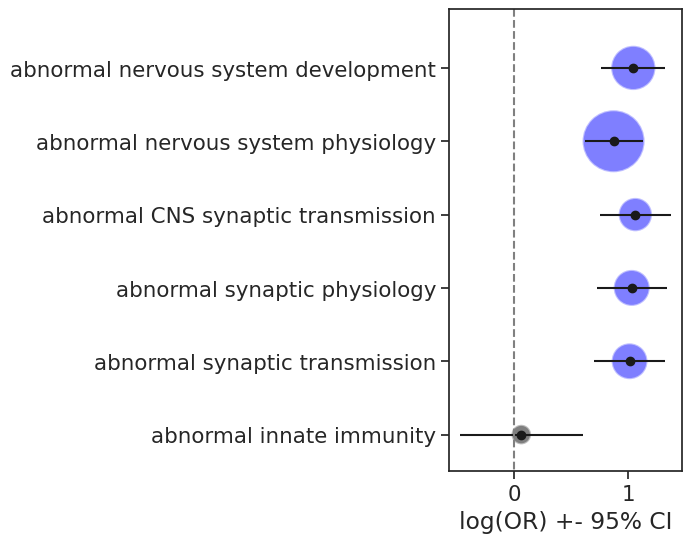

In [31]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})

sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.8,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-0.8,len(terms_plot)-.5])

plt.gca().invert_yaxis()


## 18. Compute the enrichment of phenotype(s) in NetColoc subsystems.

Some phenotypes may have stronger associations with NetColoc subsystems than with the root node. In this step we calculate the enrichment of selected phenotypes in each NetColoc subsystem.


In [32]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall
MP_full_results_df = validation.MPO_enrichment_full(hier_df,MPO,mgi_df,MP_focal_top,G_int)
MP_full_results_df.head()

,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal nervous system physiology:-log(OR_p),abnormal nervous system physiology:log_OR,abnormal nervous system physiology:num_genes,abnormal nervous system physiology:gene_ids,abnormal CNS synaptic transmission:-log(OR_p),abnormal CNS synaptic transmission:log_OR,...,abnormal synaptic depression:num_genes,abnormal synaptic depression:gene_ids,abnormal neuron morphology:-log(OR_p),abnormal neuron morphology:log_OR,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal excitatory postsynaptic currents:-log(OR_p),abnormal excitatory postsynaptic currents:log_OR,abnormal excitatory postsynaptic currents:num_genes,abnormal excitatory postsynaptic currents:gene_ids
C348,12.472092,1.045740,62,AR ASF1A CACNA2D2 CBLN1 CCKAR CREBBP DCC DDX11...,10.800246,0.873552,81,ALDH5A1 ANK2 ANKRD11 ATE1 ATR BRD4 CACNA1E CAC...,10.573716,1.063774,...,22,CACNA1G CACNA2D2 CACNA2D3 CASP6 CBLN1 EMX1 FOX...,7.454349,0.799091,60,ANK2 AR CACHD1 CACNA1G CACNA2D2 CASKIN1 CBLN1 ...,6.988154,1.238822,21,CACNA1G CACNA2D2 CACNA2D3 CASP6 CBLN1 DSCAML1 ...
C353,0.904307,0.676131,6,FOXJ1 MCIDAS RGS4 UBR2 UBR5 USP9X,1.114324,0.662650,9,ANK2 ATE1 ATR LTN1 MCIDAS PPP1R9B RGS2 UBE2A UBR2,0.516419,0.539642,...,2,PPP1R9B UBE2A,0.244067,0.270236,5,ANK2 GIGYF2 LTN1 PPP1R9B UBR2,-0.000000,0.000000,0,
C439,0.660653,1.421529,1,POFUT1,-0.000000,0.000000,0,,-0.000000,0.000000,...,0,,-0.000000,0.000000,0,,-0.000000,0.000000,0,
C414,2.693495,2.521801,3,SKI SMAD9 SMURF2,-0.000000,0.000000,0,,-0.000000,0.000000,...,0,,0.288698,0.714456,1,SMAD9,-0.000000,0.000000,0,
C394,0.942948,1.267941,2,SETD2 USP9X,0.020383,-0.060999,1,SETD2,0.325127,0.761515,...,0,,-0.000000,0.000000,0,,-0.000000,0.000000,0,


In [33]:
print("Top ten terms:")
print("\n".join([mp+" - "+validation.get_MP_description(mp, MPO) for mp in MP_focal_top]))

Top ten terms:
MP:0003861 - abnormal nervous system development
MP:0003633 - abnormal nervous system physiology
MP:0002206 - abnormal CNS synaptic transmission
MP:0021009 - abnormal synaptic physiology
MP:0003635 - abnormal synaptic transmission
MP:0002272 - abnormal nervous system electrophysiology
MP:0009939 - abnormal hippocampus neuron morphology
MP:0002915 - abnormal synaptic depression
MP:0002882 - abnormal neuron morphology
MP:0002910 - abnormal excitatory postsynaptic currents


## 19. Annotate the NetColoc systems map with mouse variant data, input genes, and enriched GO terms

In [34]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
MP_full_results_df.loc[root_node, 'gprofiler_name']=d1_name+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','frac_d1_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal nervous system physiology:-log(OR_p),abnormal nervous system physiology:log_OR,abnormal nervous system physiology:num_genes,abnormal nervous system physiology:gene_ids,abnormal CNS synaptic transmission:-log(OR_p),abnormal CNS synaptic transmission:log_OR,...,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal excitatory postsynaptic currents:-log(OR_p),abnormal excitatory postsynaptic currents:log_OR,abnormal excitatory postsynaptic currents:num_genes,abnormal excitatory postsynaptic currents:gene_ids,gprofiler_name,num_d1_seeds,frac_d1_seeds,frac_no_seeds
C348,12.472092,1.045740,62,AR ASF1A CACNA2D2 CBLN1 CCKAR CREBBP DCC DDX11...,10.800246,0.873552,81,ALDH5A1 ANK2 ANKRD11 ATE1 ATR BRD4 CACNA1E CAC...,10.573716,1.063774,...,60,ANK2 AR CACHD1 CACNA1G CACNA2D2 CASKIN1 CBLN1 ...,6.988154,1.238822,21,CACNA1G CACNA2D2 CACNA2D3 CASP6 CBLN1 DSCAML1 ...,ASD systems map,71,0.207602,0.792398
C353,0.904307,0.676131,6,FOXJ1 MCIDAS RGS4 UBR2 UBR5 USP9X,1.114324,0.662650,9,ANK2 ATE1 ATR LTN1 MCIDAS PPP1R9B RGS2 UBE2A UBR2,0.516419,0.539642,...,5,ANK2 GIGYF2 LTN1 PPP1R9B UBR2,-0.000000,0.000000,0,,E3 ubiquitin ligases ubiquitinate target proteins,9,0.204545,0.795455
C439,0.660653,1.421529,1,POFUT1,-0.000000,0.000000,0,,-0.000000,0.000000,...,0,,-0.000000,0.000000,0,,C439,1,0.250000,0.750000
C414,2.693495,2.521801,3,SKI SMAD9 SMURF2,-0.000000,0.000000,0,,-0.000000,0.000000,...,1,SMAD9,-0.000000,0.000000,0,,C414,1,0.166667,0.833333
C394,0.942948,1.267941,2,SETD2 USP9X,0.020383,-0.060999,1,SETD2,0.325127,0.761515,...,0,,-0.000000,0.000000,0,,C394,2,0.222222,0.777778


## 20. Export the NetColoc systems map to NDEx, with default style. 

Default style maps the fraction of seed genes from input set 1 (red) and input set 2 (blue) to node pie charts. The fraction of genes in each system that are in neither input set, but that are implicated by the network propagation are indicated in white.

In [35]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# Restore some hierarchy properties to their state before networkx conversion.
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite the existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='f338dea0-117c-11ec-9e8e-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [ ]:
#Upload to NDEx. Enter your ndex username and password. 
# If you are new to ndex, make a new account on the website (ndexbio.org)
G_hier_cx.set_name(d1_name+'_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

## 21. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [41]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [42]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


## 22. Add genes associated with mouse variant phenotypes to NetColoc subnetwork, export to NDEx. 

In [43]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node, MP].split(' ')
    node_df[MP]=0
    node_df.loc[focal_genes, MP]=1
node_df.head()

,d1_seeds,d1_name,z_d1,sum_seeds,abnormal nervous system development:gene_ids,abnormal nervous system physiology:gene_ids,abnormal CNS synaptic transmission:gene_ids,abnormal synaptic physiology:gene_ids,abnormal synaptic transmission:gene_ids,abnormal nervous system electrophysiology:gene_ids,abnormal hippocampus neuron morphology:gene_ids,abnormal synaptic depression:gene_ids,abnormal neuron morphology:gene_ids,abnormal excitatory postsynaptic currents:gene_ids
TCF20,1,ASD,13.894331,1,1,0,0,0,0,0,0,0,0,0
PHF2,1,ASD,11.034771,1,0,0,0,0,0,0,0,0,0,0
RFX3,1,ASD,10.759614,1,0,0,0,0,0,0,0,0,0,0
WAC,1,ASD,10.168940,1,0,0,0,0,0,0,0,0,0,0
SKI,1,ASD,8.947080,1,1,0,0,0,0,0,1,0,0,0


In [44]:

G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_prox_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_prox_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


## 23. Upload cosine-similarity transformed NetColoc subnetwork to NDEx

In [45]:
#Annotate network
print("Number of nodes in cosine similarity network:", len(G_cosSim.nodes()))
print("Number of edges in cosine similarity network:", len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

Number of nodes in cosine similarity network: 348
Number of edges in cosine similarity network: 1562
Generating CX


## 24. Add 4 networks from above to network set

In [46]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+' network set: '+datestr,'network set for '+d1_name+' NetColoc subgraph and systems map')
networkSetURL

'https://www.ndexbio.org/v2/networkset/c758457d-8757-11ef-af07-005056ae3c32'

In [47]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'https://www.ndexbio.org/v2/networkset/c758457d-8757-11ef-af07-005056ae3c32/members'